# Similarity maps

Here, I try to produce the similarity map given as input the response to a given stimuli. The matrix $X$ is the response to the stimuli $S$, with shape $(n\_channels,\;n\_time)$. I produce the similarity map $M$ with shape $(n\_channels,\;n\_channels)$ given $X$ as follows:
- $M_{ij} = cosine\_similarity(X[i,:],X[j,:])$

In [39]:
import numpy as np

def cosine_similarity(vec1, vec2):
    """Calculates the cosine similarity between two vectors."""
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    similarity = dot_product / (norm1 * norm2)
    return similarity

def euclidean_distance(vec1, vec2):
    """Calculates the euclidean distance between two vectors."""
    return np.linalg.norm(vec1 - vec2)


Load the data

In [3]:
import pandas as pd
import numpy as np

import mne
from mne import combine_evoked
from mne.minimum_norm import apply_inverse
from mne.datasets.brainstorm import bst_auditory
from mne.io import read_raw_ctf


# how to create a simulation
# https://mne.tools/dev/auto_tutorials/simulation/10_array_objs.html


################################################
############################### 1. Read the data
################################################

use_precomputed = True


data_path = bst_auditory.data_path()

subject = 'bst_auditory'
subjects_dir = data_path / 'subjects'

raw_fname1 = data_path / 'MEG' / subject / 'S01_AEF_20131218_01.ds'
raw_fname2 = data_path / 'MEG' / subject / 'S01_AEF_20131218_02.ds'
erm_fname = data_path / 'MEG' / subject / 'S01_Noise_20131218_01.ds'


raw = read_raw_ctf(raw_fname1)
n_times_run1 = raw.n_times

# Here we ignore that these have different device<->head transforms
mne.io.concatenate_raws(
    [raw, read_raw_ctf(raw_fname2)], on_mismatch='ignore')
raw_erm = read_raw_ctf(erm_fname)


raw.set_channel_types({'HEOG': 'eog', 'VEOG': 'eog', 'ECG': 'ecg'})
if not use_precomputed:
    # Leave out the two EEG channels for easier computation of forward.
    raw.pick(['meg', 'stim', 'misc', 'eog', 'ecg']).load_data()
    
annotations_df = pd.DataFrame()
offset = n_times_run1
for idx in [1, 2]:
    csv_fname = data_path / 'MEG' / 'bst_auditory' / f'events_bad_0{idx}.csv'
    df = pd.read_csv(csv_fname, header=None,
                     names=['onset', 'duration', 'id', 'label'])
    print('Events from run {0}:'.format(idx))
    print(df)

    df['onset'] += offset * (idx - 1)
    annotations_df = pd.concat([annotations_df, df], axis=0)

saccades_events = df[df['label'] == 'saccade'].values[:, :3].astype(int)

# Conversion from samples to times:
onsets = annotations_df['onset'].values / raw.info['sfreq']
durations = annotations_df['duration'].values / raw.info['sfreq']
descriptions = annotations_df['label'].values

annotations = mne.Annotations(onsets, durations, descriptions)
raw.set_annotations(annotations)
del onsets, durations, descriptions

print('Annotations:', raw.get_data('meg').shape)

tmin, tmax = -0.1, 0.5
event_id = dict(standard=1, deviant=2)
reject = dict(mag=4e-12, eog=250e-6)
# find events
events = mne.find_events(raw, stim_channel='UPPT001')

sound_data = raw[raw.ch_names.index('UADC001-4408')][0][0]
onsets = np.where(np.abs(sound_data) > 2. * np.std(sound_data))[0]
min_diff = int(0.5 * raw.info['sfreq'])
diffs = np.concatenate([[min_diff + 1], np.diff(onsets)])
onsets = onsets[diffs > min_diff]
assert len(onsets) == len(events)
diffs = 1000. * (events[:, 0] - onsets) / raw.info['sfreq']
print('Trigger delay removed (μ ± σ): %0.1f ± %0.1f ms'
      % (np.mean(diffs), np.std(diffs)))
events[:, 0] = onsets
del sound_data, diffs

raw.info['bads'] = ['MLO52-4408', 'MRT51-4408', 'MLO42-4408', 'MLO43-4408']

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=['meg', 'eog'], baseline=(None, 0), reject=reject, preload=False, proj=True)

epochs.drop_bad()

# avoid warning about concatenating with annotations
epochs.set_annotations(None)

ds directory : /Users/riccardotedoldi/mne_data/MNE-brainstorm-data/bst_auditory/MEG/bst_auditory/S01_AEF_20131218_01.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       2.51   74.26    0.00 mm <->    2.51   74.26    0.00 mm (orig :  -56.69   50.20 -264.38 mm) diff =    0.000 mm
      -2.51  -74.26    0.00 mm <->   -2.51  -74.26    0.00 mm (orig :   50.89  -52.31 -265.88 mm) diff =    0.000 mm
     108.63    0.00    0.00 mm <->  108.63    0.00   -0.00 mm (orig :   67.41   77.68 -239.53 mm) diff =    0.000 mm
    Coordinate transformations established.
    Reading digitizer points from ['/Users/riccardotedoldi/mne_data/MNE-brainstorm-data/bst_auditory/MEG/bst_auditory/S01_AEF_20131218_01.ds/S01_20131218_01.pos']...
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
    5 extra points added to Polhemus data.
    Measurement info composed.
Finding samples for 

Number of events,440
Events,deviant: 75standard: 365
Time range,-0.100 – 0.500 sec
Baseline,-0.100 – 0.000 sec


Loading data for 440 events and 1441 original time points ...


<Axes: >

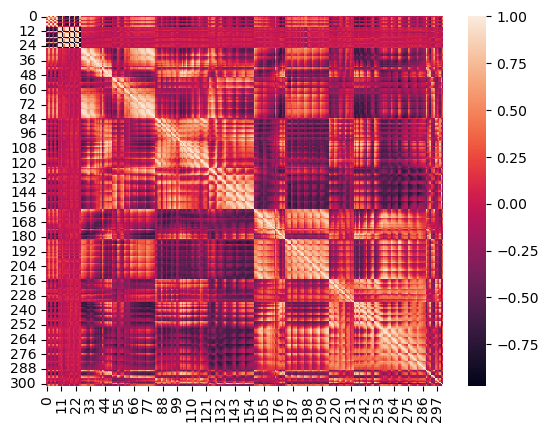

In [4]:
# shape (20, 50)
e_1 = epochs.get_data()[0]

import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(np.stack([np.stack([cosine_similarity(i, j) for j in e_1]) for i in e_1]))

Loading data for 440 events and 1441 original time points ...


<Axes: >

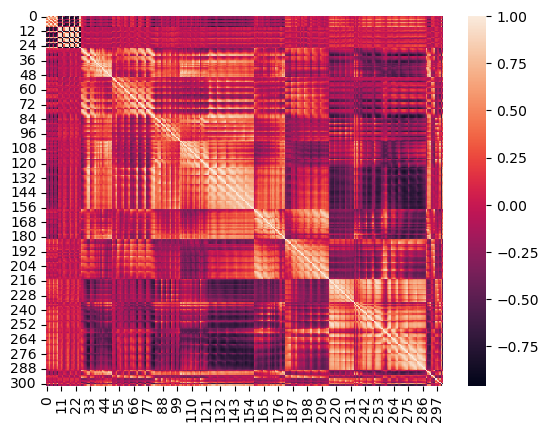

In [14]:
# shape (20, 50)
e_10 = epochs.get_data()[10]

import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(np.stack([np.stack([cosine_similarity(i, j) for j in e_10]) for i in e_10]))

In [5]:
X = epochs.get_data()

Loading data for 440 events and 1441 original time points ...


In [11]:
sim_maps = np.stack([np.stack([np.stack([cosine_similarity(i, j) for j in e]) for i in e]) for e in X[:100]])

Here I compute the distances in between the similarity maps in the responses to a given stimuli. Additionally, I normalized the result by the root of the dimension of the matrix. This is done to avoid the fact that whenever the number of channels increases we obtain completely different values in term of the fitness.

In [44]:
sim_maps_distance = np.stack([
                        np.stack([
                            np.sum(abs(sim_maps[i]-sim_maps[j]))/np.sqrt(sim_maps[j].shape[0]) for i in range(len(sim_maps)) if i != j
                            ]) for j in range(len(sim_maps))
                                ])

sim_maps_distance.shape

(100, 99)

<Axes: title={'center': 'Cosine Similarity'}>

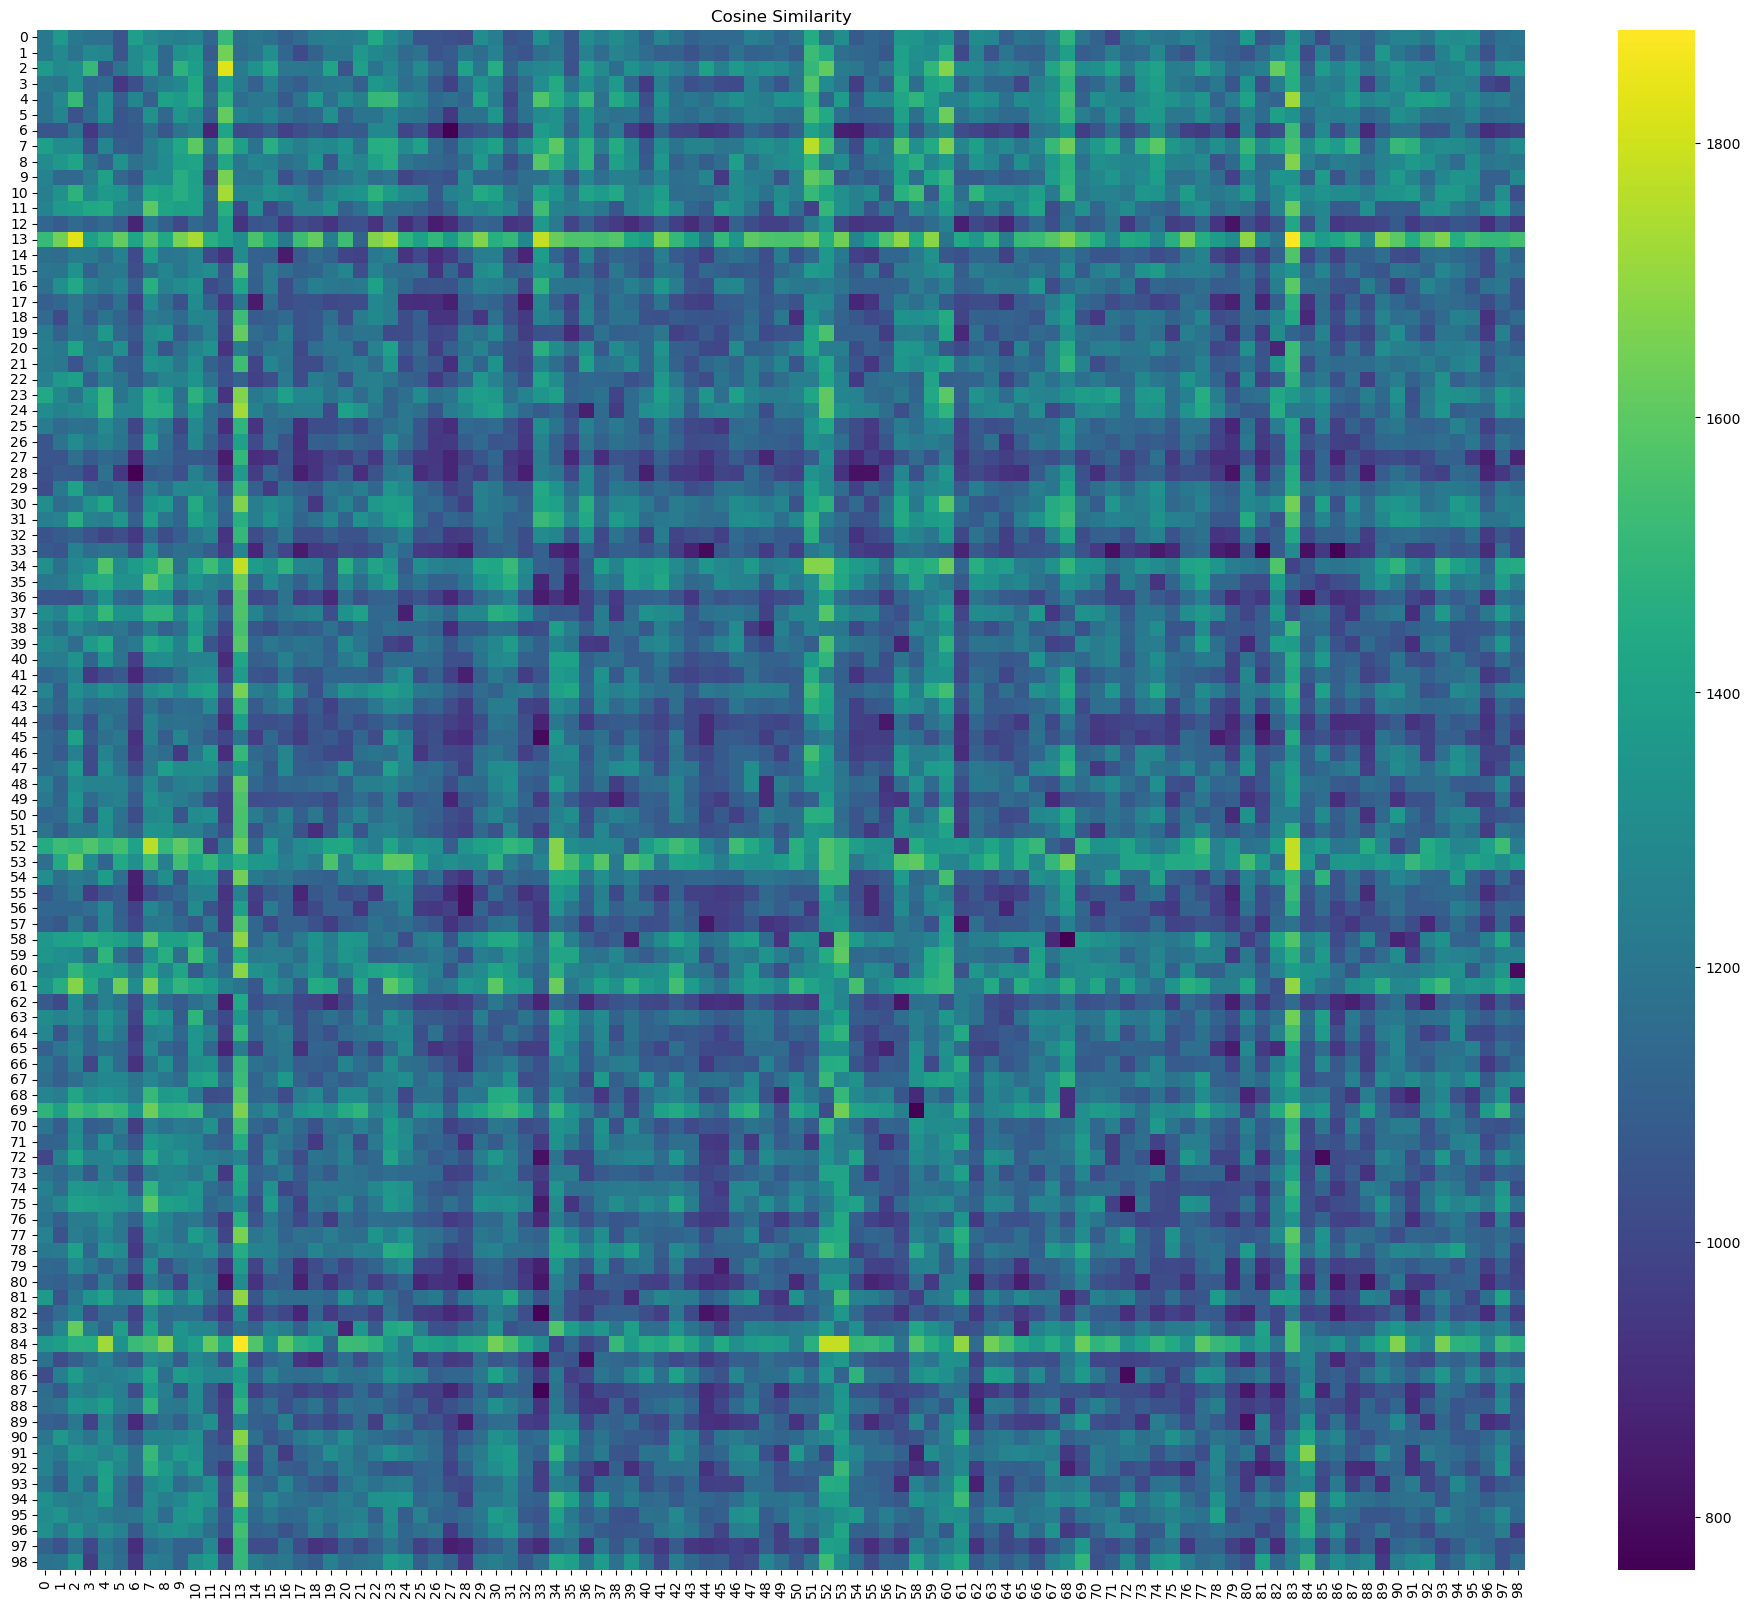

In [45]:
import seaborn as sns

plt.figure(figsize=(24, 20))
plt.title('Cosine Similarity')
sns.heatmap(sim_maps_distance[:99], cmap='viridis')

<Axes: title={'center': 'Cosine Similarity'}>

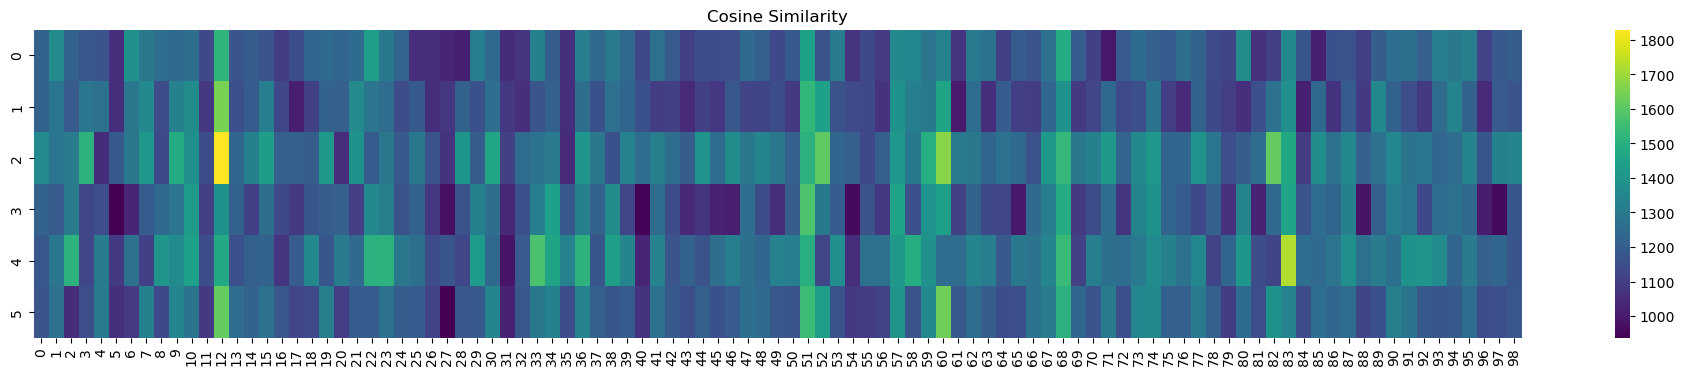

In [49]:
import seaborn as sns

plt.figure(figsize=(24, 4))
plt.title('Cosine Similarity')
sns.heatmap(sim_maps_distance[:6], cmap='viridis')

In [40]:
sim_maps_euclidean = np.stack([np.stack([np.stack([euclidean_distance(i, j) for j in e]) for i in e]) for e in X[:100]])

In [50]:
sim_maps_distance = np.stack([
                        np.stack([
                            np.sum(abs(sim_maps_euclidean[i]-sim_maps_euclidean[j]))/np.sqrt(sim_maps_euclidean[j].shape[0]) for i in range(len(sim_maps_euclidean)) if i != j
                            ]) for j in range(len(sim_maps_euclidean))
                                ])

sim_maps_distance.shape

(100, 99)

Map which enccode which are the differences in terms of the response to the same stimulus given the same subject.

<Axes: title={'center': 'Euclidean distance'}>

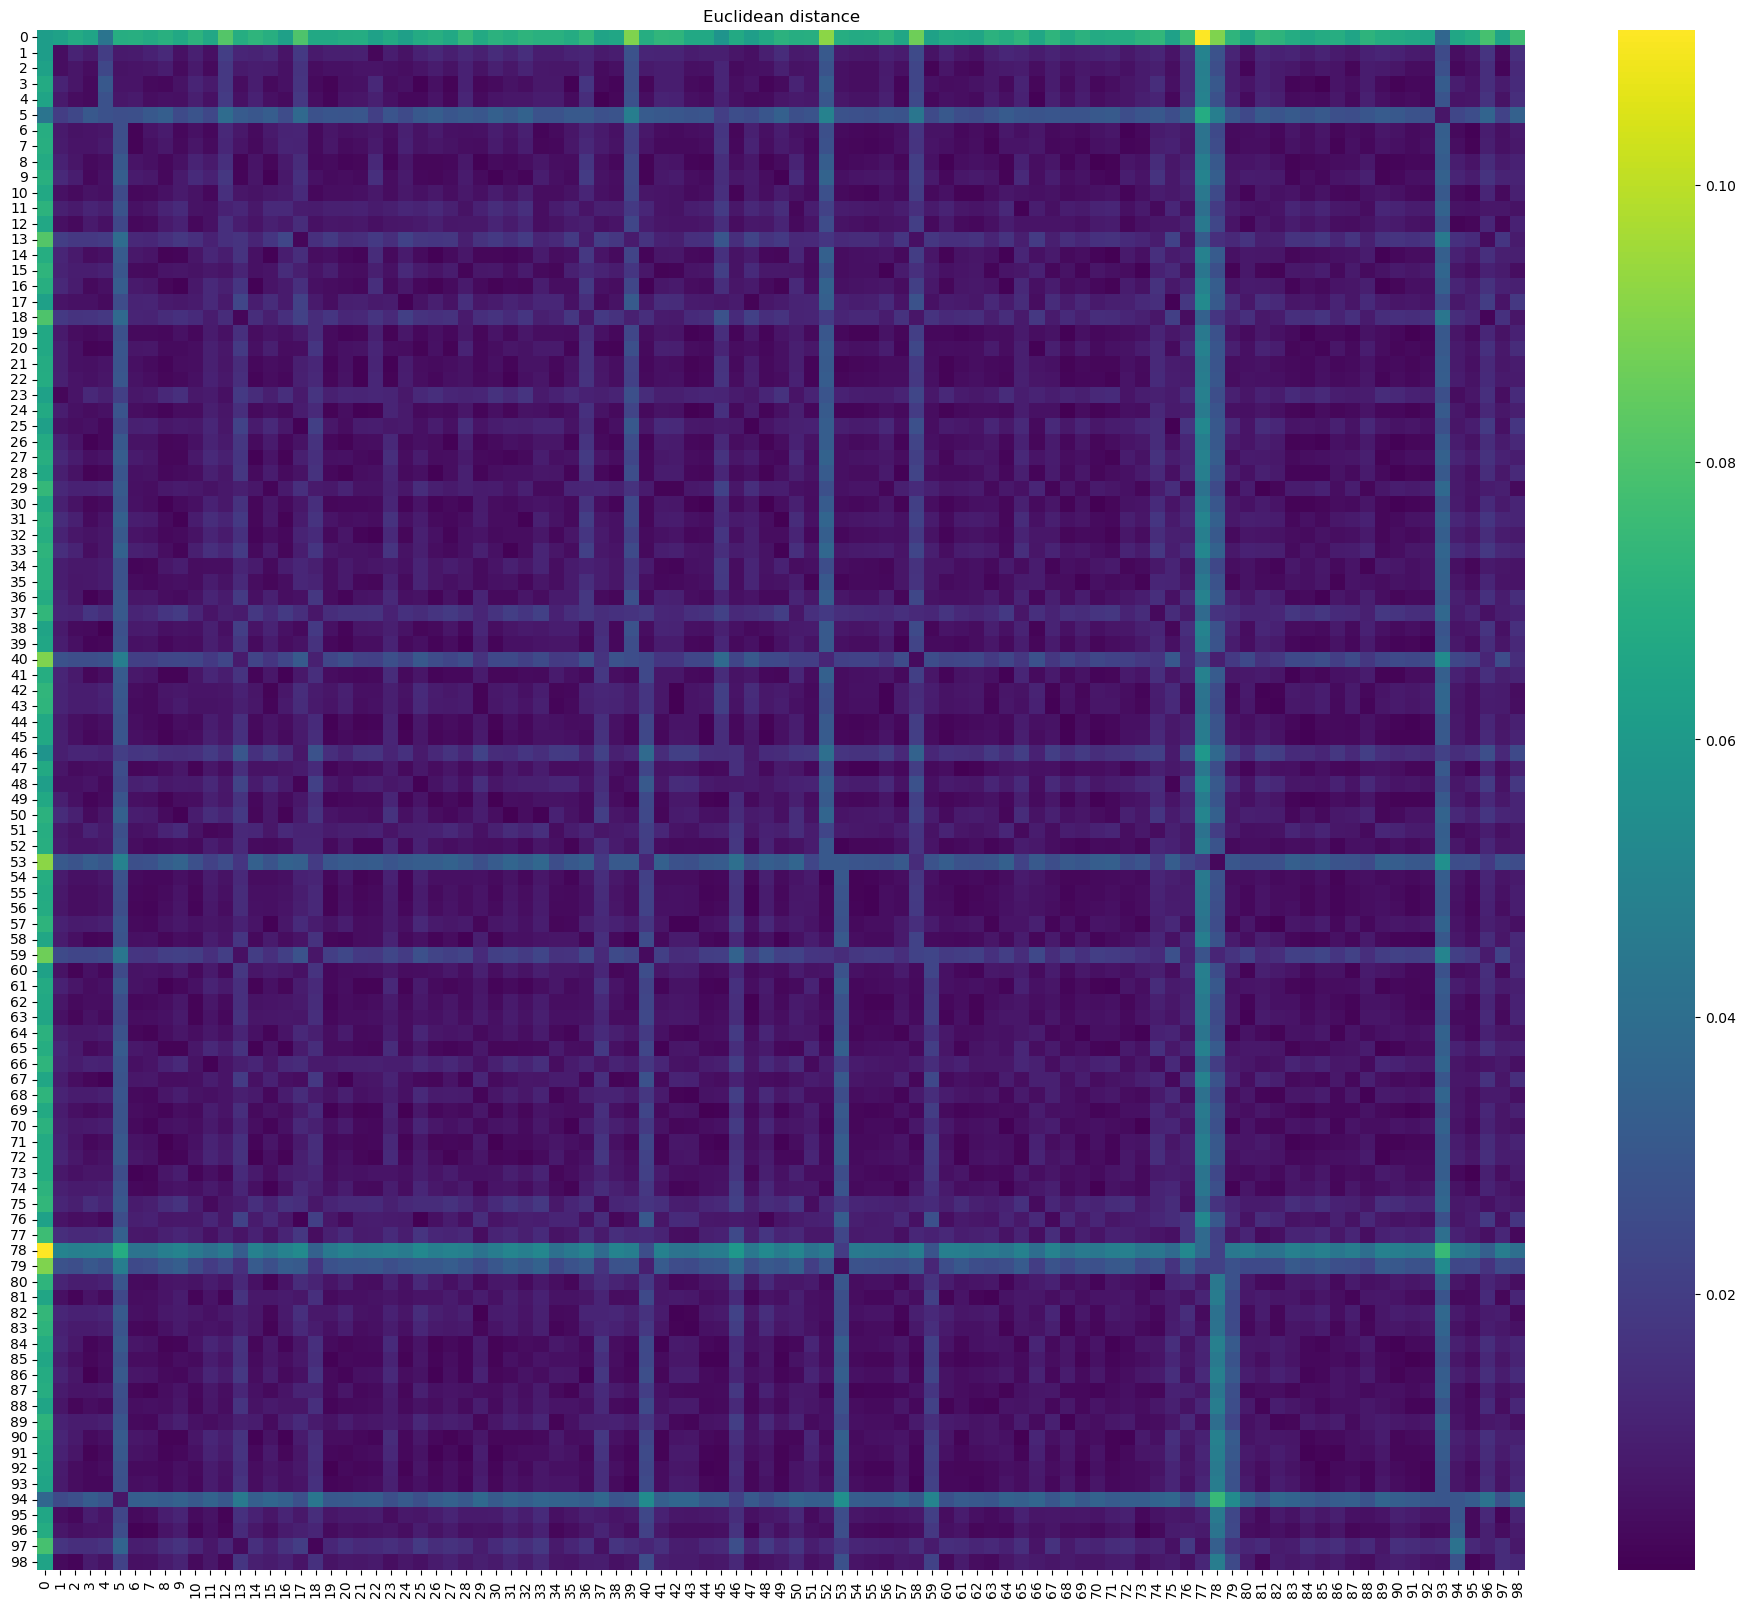

In [43]:
import seaborn as sns

plt.figure(figsize=(24, 20))
plt.title('Euclidean distance')
sns.heatmap(sim_maps_distance[:99], cmap='viridis')

<Axes: title={'center': 'Euclidean distance'}>

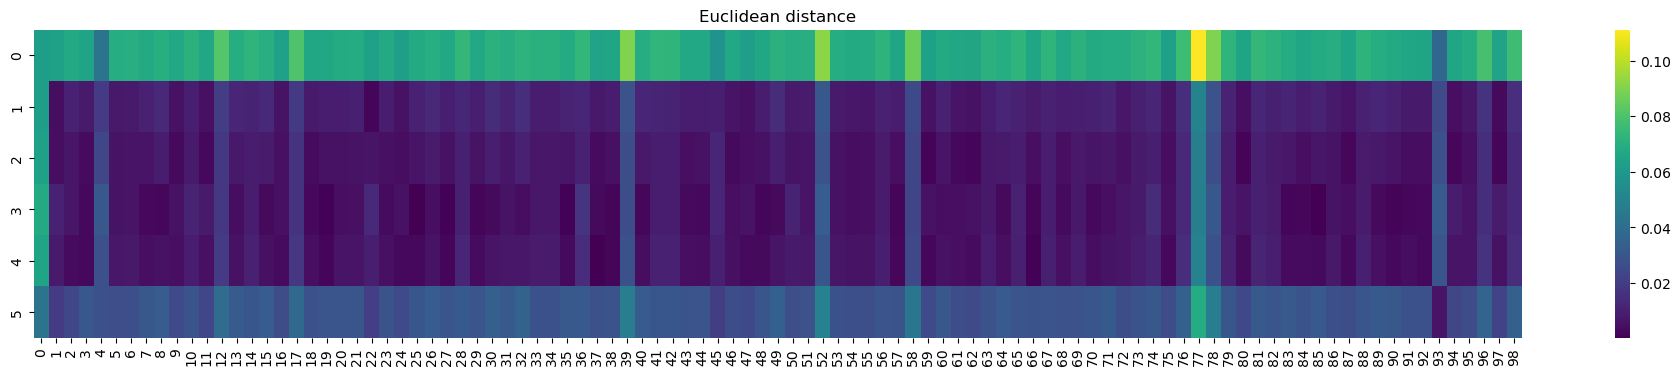

In [51]:
import seaborn as sns

plt.figure(figsize=(24, 4))
plt.title('Euclidean distance')
sns.heatmap(sim_maps_distance[:6], cmap='viridis')

In [69]:
epochs.get_data(picks=list(range(10))).shape

Loading data for 440 events and 1441 original time points ...


(440, 10, 1441)

In [21]:
import mne

7,0,1,3,7

7,0,1,3,7

7,0,1,3,7

7,0,1,3,7

7,0,1,3,7

opm_data_folder = mne.datasets.ucl_opm_auditory.data_path()

AttributeError: module 'mne.datasets' has no attribute 'ucl_opm_auditory'

In [33]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP

# info dataset
# https://physionet.org/content/eegmmidb/1.0.0/

# #############################################################################
# # Set parameters and read data

# avoid classification of evoked responses by using epochs that start 1s after
# cue onset.
tmin, tmax = -1.0, 4.0
event_id = dict(hands=2, feet=3)
subject = 2
runs = [6, 10, 14]  # motor imagery: hands vs feet

raw_fnames = eegbci.load_data(subject, runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
eegbci.standardize(raw)  # set channel names
montage = make_standard_montage("standard_1005")
raw.set_montage(montage)

# Apply band-pass filter
raw.filter(4.0, 40.0, fir_design="firwin", skip_by_annotation="edge")

events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))

picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

# Read epochs (train will be done only between 1 and 2s)
# Testing will be done with a running classifier
epochs = Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,
)
epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)
labels = epochs.events[:, -1] - 2

Automatically created module for IPython interactive environment
Extracting EDF parameters from /Users/riccardotedoldi/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /Users/riccardotedoldi/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Extracting EDF parameters from /Users/riccardotedoldi/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S002/S002R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19679  =      0.000 ...   122.994 secs...
Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 4 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


In [34]:

epochs_train.get_data().shape

(45, 64, 161)